In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib


drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/DL_HW/weather_dataset/'

data_dir = pathlib.Path(data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

539


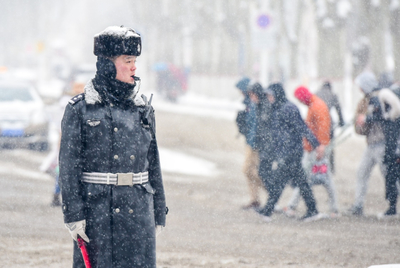

In [7]:
snow=list(data_dir.glob('snow/*.jpg'))
PIL.Image.open(str(snow[0]))

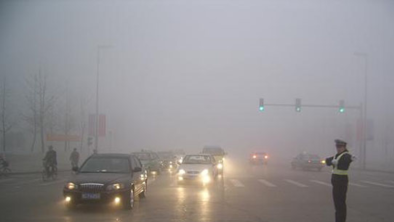

In [8]:
fogsmog=list(data_dir.glob('fogsmog/*.jpg'))
PIL.Image.open(str(fogsmog[0]))

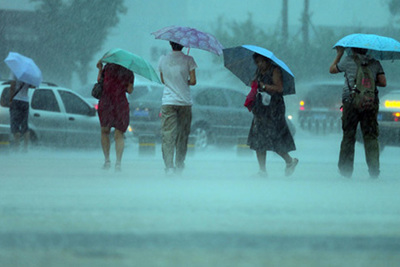

In [9]:
rain=list(data_dir.glob('rain/*.jpg'))
PIL.Image.open(str(rain[0]))

# STEP 2

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 539 files belonging to 3 classes.
Using 432 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 539 files belonging to 3 classes.
Using 107 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['fogsmog', 'rain', 'snow']


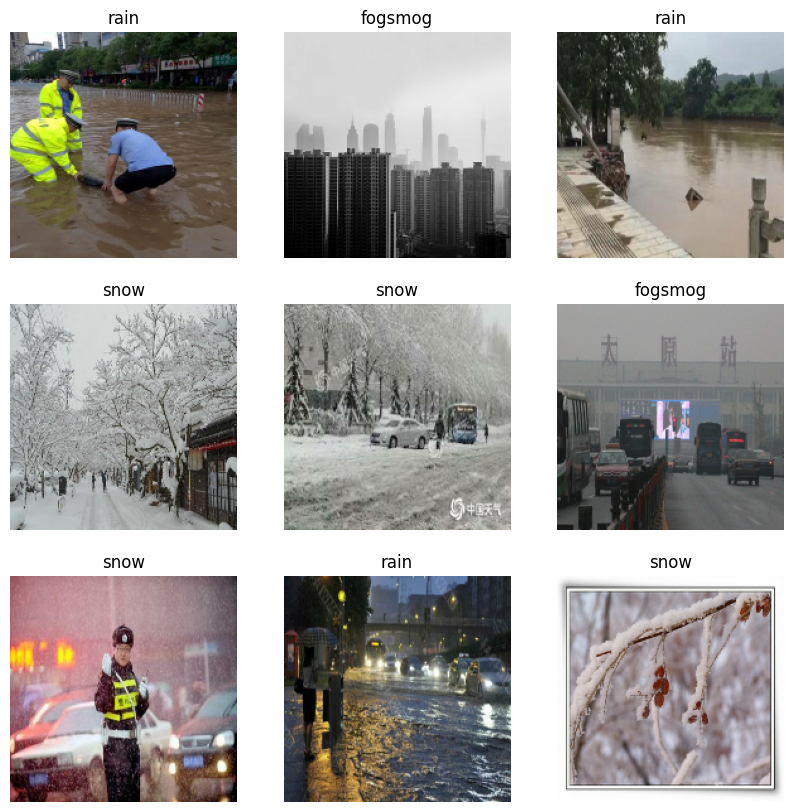

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 3: PreProcessing

 **Normalization**

In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


 **Data Augumentation**

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Step 4: CNN model

In [29]:
num_classes = 3

cnn_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [30]:
epochs=10
cnn_history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 2s 39ms/step - loss: 1.1174 - accuracy: 0.4630 - val_loss: 0.8459 - val_accuracy: 0.7570
Epoch 2/10
14/14 [==============================] - 0s 23ms/step - loss: 0.7218 - accuracy: 0.7130 - val_loss: 0.6228 - val_accuracy: 0.7850
Epoch 3/10
14/14 [==============================] - 0s 23ms/step - loss: 0.5680 - accuracy: 0.7407 - val_loss: 0.6820 - val_accuracy: 0.7477
Epoch 4/10
14/14 [==============================] - 0s 27ms/step - loss: 0.5198 - accuracy: 0.7755 - val_loss: 0.4944 - val_accuracy: 0.8131
Epoch 5/10
14/14 [==============================] - 0s 27ms/step - loss: 0.4342 - accuracy: 0.8287 - val_loss: 0.4958 - val_accuracy: 0.8037
Epoch 6/10
14/14 [==============================] - 0s 26ms/step - loss: 0.4246 - accuracy: 0.8287 - val_loss: 0.4427 - val_accuracy: 0.8037
Epoch 7/10
14/14 [==============================] - 0s 28ms/step - loss: 0.3782 - accuracy: 0.8519 - val_loss: 0.4610 - val_accuracy: 0.7850
Epoch 8/10
14

4/4 [==============================] - 0s 9ms/step - loss: 0.3354 - accuracy: 0.8879
Overall Validation Accuracy: 0.8878504633903503


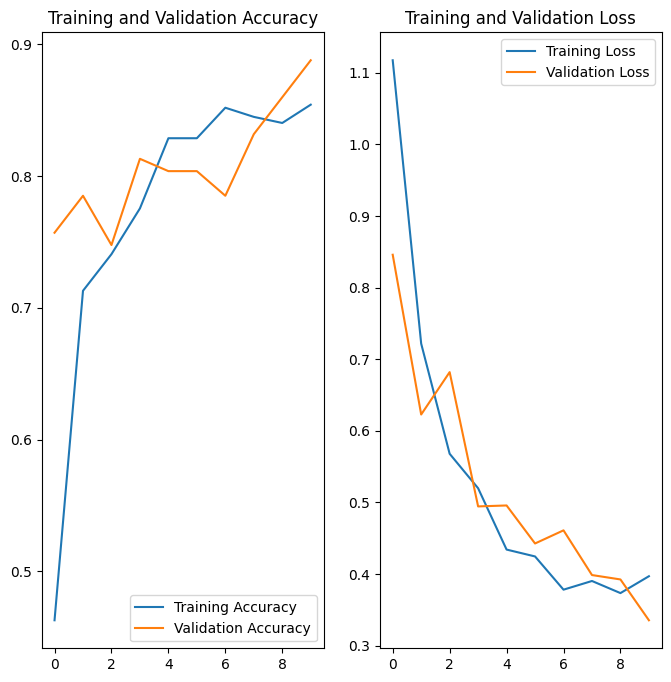

In [31]:
cnn_acc = cnn_history.history['accuracy']
cnn_val_acc = cnn_history.history['val_accuracy']

cnn_loss = cnn_history.history['loss']
cnn_val_loss = cnn_history.history['val_loss']

overall_val_accuracy = cnn_model.evaluate(val_ds)[1]
print("Overall Validation Accuracy:", overall_val_accuracy)


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cnn_acc, label='Training Accuracy')
plt.plot(epochs_range, cnn_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cnn_loss, label='Training Loss')
plt.plot(epochs_range, cnn_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 87ms/step
[[-6.752391   2.7044864  4.180106 ]]
2


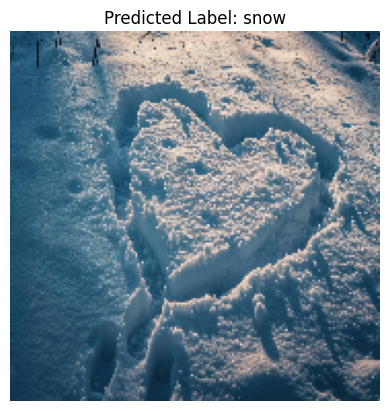

1/1 [==============================] - 0s 18ms/step
[[-4.7557845  2.408226   1.9624339]]
1


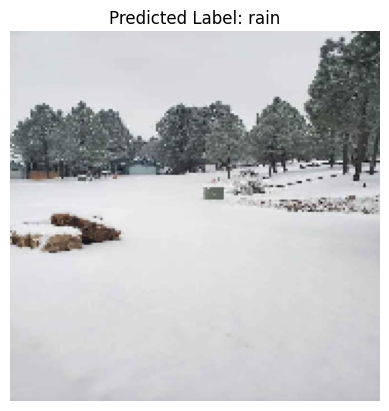

1/1 [==============================] - 0s 18ms/step
[[-3.1437557   3.0759573   0.83504236]]
1


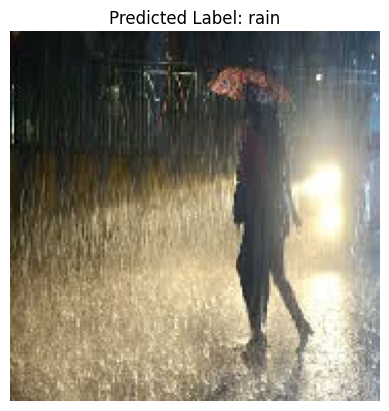

1/1 [==============================] - 0s 25ms/step
[[ 1.7892632 -2.372418  -2.4183397]]
0


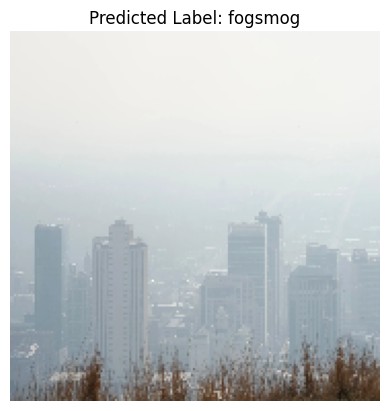

In [32]:
#Test with UNSEEN DATA

test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'

test_dir = pathlib.Path(test_dir)

# Iterate over the images in the test directory
for image_path in test_dir.glob("*"):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    # Perform prediction
    prediction = cnn_model.predict(img_array)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    print(predicted_label)

    # Decode the predicted label (assuming you have a list of class names)
    predicted_class = class_names[predicted_label]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_class}")
    plt.axis("off")
    plt.show()

# Step 6: GoogleNet

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/10
14/14 [==============================] - 15s 458ms/step - loss: 81.8933 - accuracy: 0.5324 - val_loss: 24.7617 - val_accuracy: 0.6729
Epoch 2/10
14/14 [==============================] - 1s 62ms/step - loss: 17.0147 - accuracy: 0.6574 - val_loss: 12.6553 - val_accuracy: 0.7103
Epoch 3/10
14/14 [==============================] - 1s 55ms/step - loss: 9.6029 - accuracy: 0.7292 - val_loss: 12.4064 - val_accuracy: 0.6822
Epoch 4/10
14/14 [==============================] - 1s 55ms/step - loss: 5.7294 - accuracy: 0.7454 - val_loss: 5.4698 - val_accuracy: 0.7944
Epoch 5/10
14/14 [==============================] - 1s 55ms/step - loss: 2.4312 - accuracy: 0.7940 - val_loss: 3.3277 - val_accuracy: 0.7664
Epoch 6/10
14/14 [==============================] - 1s 56ms/step - loss: 2.3203 - accuracy: 0.7708 - val_loss: 3.6581 - val_accuracy: 0.7477
Epoch 7/10
14/14 [==============================] - 1s 57ms/step - loss: 1.9161 - 

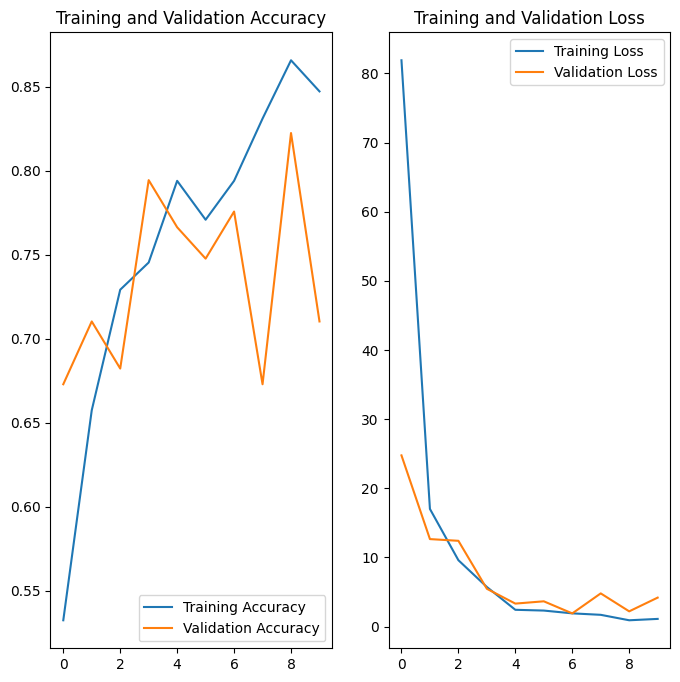

1/1 [==============================] - 2s 2s/step
[[1.0994624e-30 3.9105718e-03 9.9608946e-01]]
2


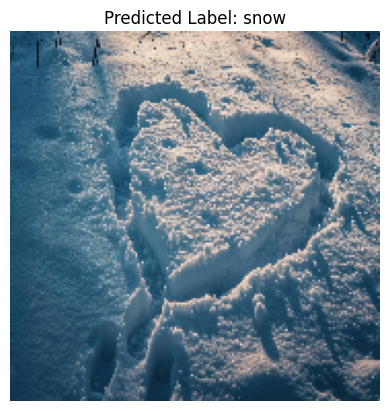

1/1 [==============================] - 0s 34ms/step
[[0.0000000e+00 1.0000000e+00 5.1015043e-08]]
1


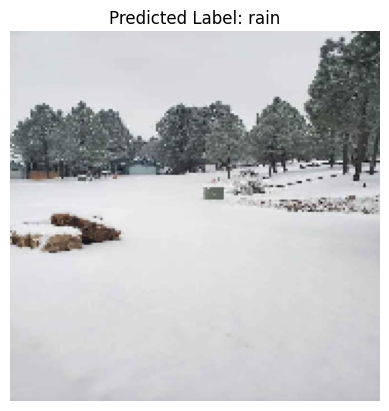

1/1 [==============================] - 0s 26ms/step
[[2.4638540e-36 3.6124742e-01 6.3875252e-01]]
2


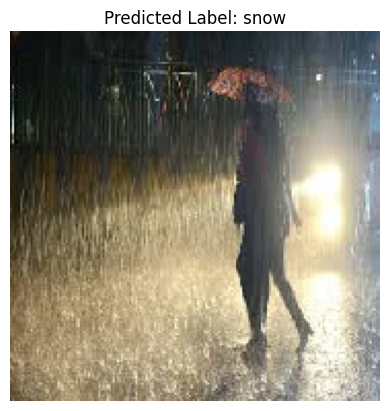

1/1 [==============================] - 0s 25ms/step
[[1.0000000e+00 3.1336635e-18 2.8573836e-25]]
0


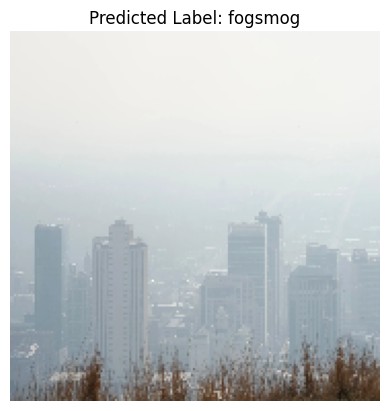

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator



num_classes =3
inception_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

x = inception_net.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

inception_model = Model(inputs=inception_net.input, outputs=predictions)

for layer in inception_net.layers:
   layer.trainable = False


inception_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


epochs=10
inceptionnet_history = inception_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


inc_acc = inceptionnet_history.history['accuracy']
inc_val_acc = inceptionnet_history.history['val_accuracy']

inc_loss = inceptionnet_history.history['loss']
inc_val_loss = inceptionnet_history.history['val_loss']

overall_val_accuracy = inception_model.evaluate(val_ds)[1]
print("Overall Validation Accuracy:", overall_val_accuracy)


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, inc_acc, label='Training Accuracy')
plt.plot(epochs_range, inc_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, inc_loss, label='Training Loss')
plt.plot(epochs_range, inc_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#TEST ON UNSEEN DATA


test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'

test_dir = pathlib.Path(test_dir)

# Iterate over the images in the test directory
for image_path in test_dir.glob("*"):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    # Perform prediction
    prediction = inception_model.predict(img_array)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    print(predicted_label)

    # Decode the predicted label (assuming you have a list of class names)
    predicted_class = class_names[predicted_label]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_class}")
    plt.axis("off")
    plt.show()

with data augumentation and Dropout

Epoch 1/15
14/14 [==============================] - 10s 218ms/step - loss: 43.2788 - accuracy: 0.5417 - val_loss: 16.7340 - val_accuracy: 0.6822
Epoch 2/15
14/14 [==============================] - 2s 112ms/step - loss: 29.4850 - accuracy: 0.6481 - val_loss: 11.5115 - val_accuracy: 0.7944
Epoch 3/15
14/14 [==============================] - 2s 109ms/step - loss: 23.1642 - accuracy: 0.6551 - val_loss: 7.3293 - val_accuracy: 0.7664
Epoch 4/15
14/14 [==============================] - 4s 196ms/step - loss: 12.3720 - accuracy: 0.6898 - val_loss: 12.6304 - val_accuracy: 0.6355
Epoch 5/15
14/14 [==============================] - 2s 113ms/step - loss: 13.8681 - accuracy: 0.6528 - val_loss: 8.1514 - val_accuracy: 0.6729
Epoch 6/15
14/14 [==============================] - 3s 123ms/step - loss: 10.1545 - accuracy: 0.6574 - val_loss: 3.8405 - val_accuracy: 0.8037
Epoch 7/15
14/14 [==============================] - 2s 109ms/step - loss: 5.5623 - accuracy: 0.6852 - val_loss: 2.8271 - val_accuracy: 0.8

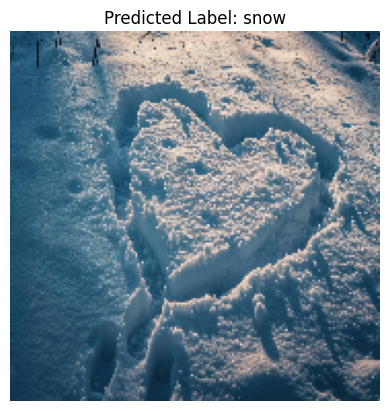

1/1 [==============================] - 0s 38ms/step
[[0.01119196 0.49360055 0.49520743]]
2


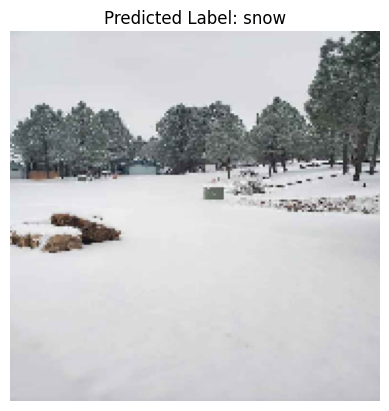

1/1 [==============================] - 0s 26ms/step
[[5.7157222e-06 4.9750760e-01 5.0248665e-01]]
2


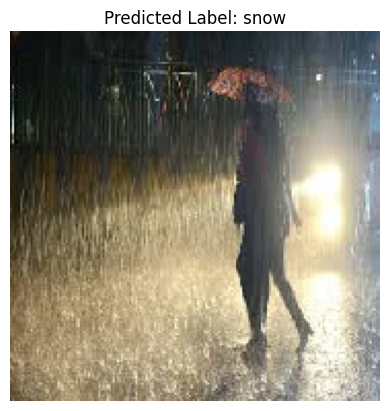

1/1 [==============================] - 0s 30ms/step
[[9.9999988e-01 9.4617086e-08 4.9080101e-10]]
0


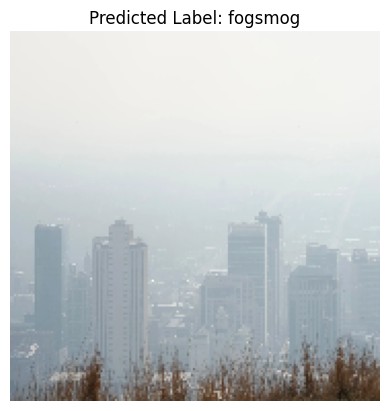

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator


num_classes = 3

# Load InceptionNet without the top layers
inception_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Apply data augmentation to input
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)

# Include InceptionV3 model
x = inception_net(x, training=False)

# Add custom linear layer on top
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
x = layers.Dense(1024, activation='relu')(x)  # Custom dense layer
x = layers.Dropout(0.5)(x)  # Dropout layer
predictions = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

# Combine base model and custom layers
inception_model_1 = Model(inputs=inputs, outputs=predictions)


for layer in inception_net.layers:
   layer.trainable = False

# Compile the model
inception_model_1.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

epochs = 15
inceptionnet_history_1= inception_model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)




overall_val_accuracy = inception_model_1.evaluate(val_ds)[1]
print("Overall Validation Accuracy:", overall_val_accuracy)


#TEST ON UNSEEN DATA


test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'

test_dir = pathlib.Path(test_dir)

# Iterate over the images in the test directory
for image_path in test_dir.glob("*"):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    # Perform prediction
    prediction = inception_model_1.predict(img_array)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    print(predicted_label)

    # Decode the predicted label (assuming you have a list of class names)
    predicted_class = class_names[predicted_label]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_class}")
    plt.axis("off")
    plt.show()



# Results and Discussion

1) The CNN model provides an overall accuracy of 0.88%

2) Transfer Learning : The Google inceptionNet model updated with an linear layer on top provided an accuracy of 0.71%

3) Inception Net model is tuned by increasing the epoches , data agumentation along with dropout of 0.2 improved the performance to 0.74%

4) The Base CNN Model provides better accuracy for this usecase than Inceptionnet.